# UBC Scientific Software Seminar

October 20, 2017

* New York City Taxi Trip Duration
  * Dates and distance
  * Outliers
  * Clusters
  * Visualizations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import the data

Let's begin by importing the data. We know that the columns at index 2 and 3 are dates and so we use the datetime parser when reading the .csv file.

In [2]:
data = pd.read_csv("train.csv",parse_dates=[2,3])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


There are over 1.4 million samples and 9 features (not including the `id` column or the `trip_duration` column which is the target) in the dataset.

In [4]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Extract date features

In [5]:
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour
data['month'] = data['pickup_datetime'].dt.month
data['dayofweek'] = data['pickup_datetime'].dt.weekday_name

In [6]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day,hour,month,dayofweek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,17,3,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,0,6,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,11,1,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,19,4,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,13,3,Saturday


In [7]:
trips_per_day = data.groupby(['dayofweek','hour'])['id'].count().unstack().transpose()
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
trips_per_day = trips_per_day[days]

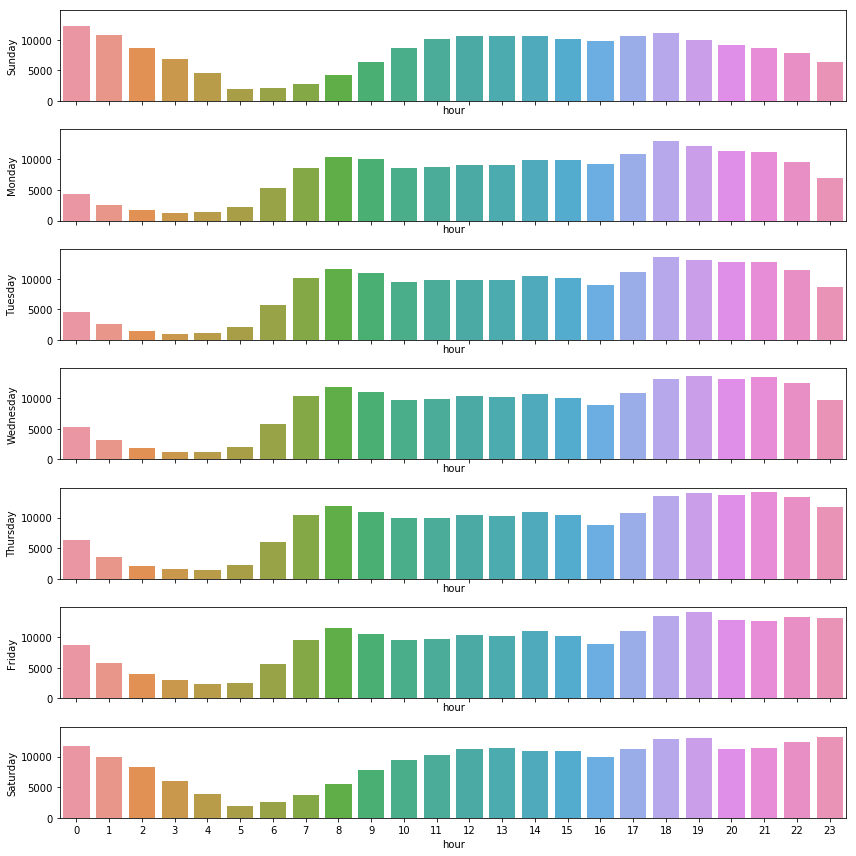

In [9]:
fig, axes = plt.subplots(7,1,figsize=(12,12),sharex=True,sharey=True)
for i, day in enumerate(days):
    sns.barplot(x=trips_per_day.index,y=trips_per_day[day],ax=axes[i]);

plt.tight_layout()

### Extract distance feature

In [11]:
def distance(row):
    R = 6373.0
    lon1, lat1, lon2, lat2 = np.radians(row)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [13]:
distance([-123.246644,49.263489,-122.915338,49.282081]) # UBC to SFU

24.132567500390628

In [10]:
coordinates = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
data['distance'] = data[coordinates].apply(distance,axis=1)

### Geographical outliers

There are some *very* weird samples in the data. Let's look at some basic statistics for the coordinates.

In [17]:
data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Longitude -121 is in California! Longitude -61 is in Nova Scotia! Latitude 34 is in South Carolina! Latitude 51 is in Canada!

![Longitude/Latitude Map](http://www.worldatlas.com/webimage/countrys/usanewzd.gif)

Clearly we should exclude the outliers. Let's find boundaries on the coordinates that pick out the samples between the 0.01% and 99.99% quantiles of coordinates.

In [18]:
quantiles = data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].quantile([0.001,0.999])
print(quantiles)

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude
0.001        -74.017220        40.641506         -74.177612         40.604228
0.999        -73.776688        40.842482         -73.739758         40.889552


In [19]:
geo_outliers = data[  (~data['pickup_longitude'].between(*quantiles['pickup_longitude']))
                | (~data['pickup_latitude'].between(*quantiles['pickup_latitude']))
                | (~data['dropoff_longitude'].between(*quantiles['dropoff_longitude']))
                | (~data['dropoff_latitude'].between(*quantiles['dropoff_latitude']))].copy()

In [20]:
geo_outliers.shape

(10182, 16)

In [21]:
data = data.drop(geo_outliers.index)

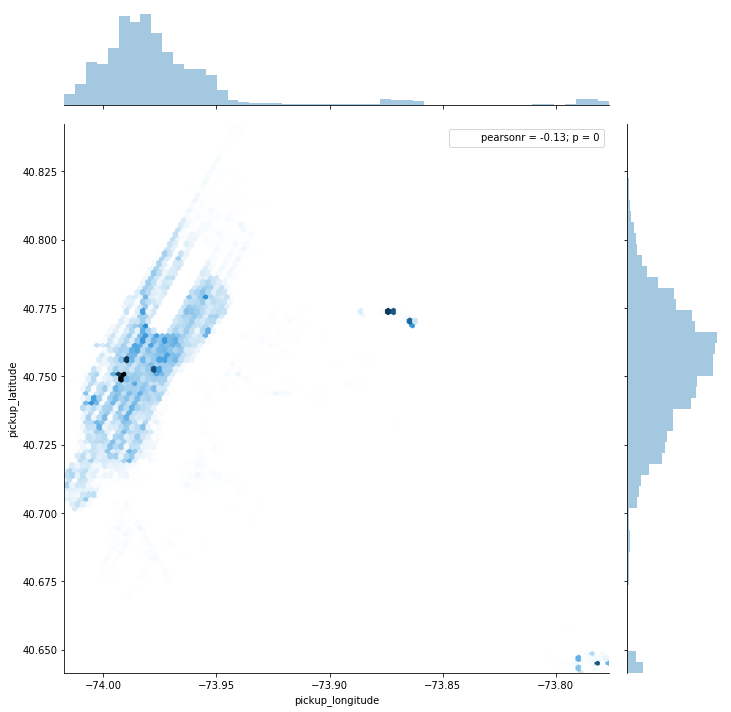

In [22]:
sns.jointplot(x='pickup_longitude',y='pickup_latitude',data=data,kind='hex',gridsize=100,size=10);

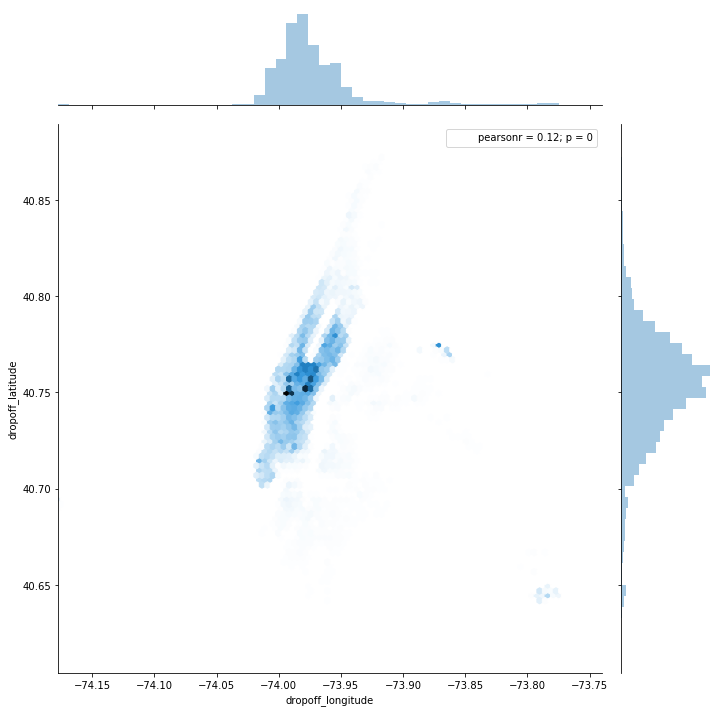

In [23]:
sns.jointplot(x='dropoff_longitude',y='dropoff_latitude',data=data,kind='hex',gridsize=100,size=10);

### Duration outliers

In [24]:
data['trip_duration'].sort_values().tail(10)

753765       86379
1360439      86385
59891        86387
73816        86390
295382       86391
1234291      86392
355003     1939736
680594     2049578
924150     2227612
978383     3526282
Name: trip_duration, dtype: int64

In [25]:
data[data['trip_duration'] > 87000]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day,hour,month,dayofweek,distance
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,5,0,1,Tuesday,20.154989
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,13,22,2,Saturday,5.984365
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,5,6,1,Tuesday,1.635641
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,13,22,2,Saturday,19.906909


In [26]:
time_outliers = data[data['trip_duration'] > 87000].copy()

In [27]:
data = data.drop(time_outliers.index)

In [28]:
data.shape

(1448458, 16)

In [29]:
data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.448458e+06,1.448458e+06,1.448458e+06,1.448458e+06,1.448458e+06
mean,-7.397387e+01,4.075113e+01,-7.397357e+01,4.075191e+01,9.465318e+02
std,3.697431e-02,2.732428e-02,3.359728e-02,3.112207e-02,3.166854e+03
min,-7.401722e+01,4.064151e+01,-7.417761e+01,4.060423e+01,1.000000e+00
25%,-7.399187e+01,4.073755e+01,-7.399131e+01,4.073617e+01,3.960000e+02
50%,-7.398178e+01,4.075419e+01,-7.397980e+01,4.075459e+01,6.600000e+02
75%,-7.396755e+01,4.076836e+01,-7.396322e+01,4.076976e+01,1.068000e+03
max,-7.377669e+01,4.084248e+01,-7.373978e+01,4.088955e+01,8.639200e+04


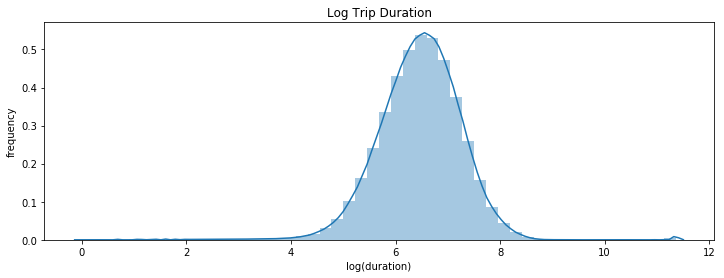

In [30]:
plt.figure(figsize=(12,4))
sns.distplot(np.log(data['trip_duration']));
plt.title('Log Trip Duration'), plt.xlabel('log(duration)'), plt.ylabel('frequency');

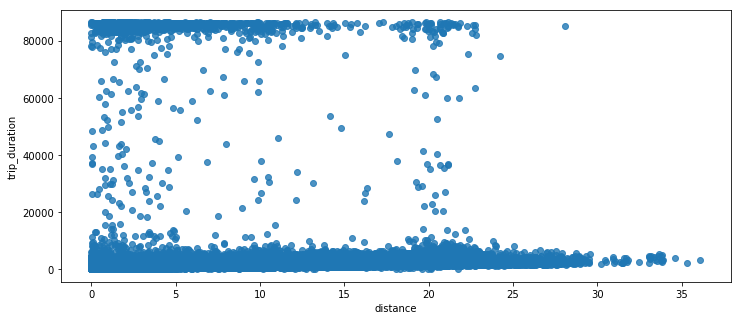

In [31]:
plt.figure(figsize=(12,5))
sns.regplot(x='distance',y='trip_duration',data=data,fit_reg=False);

### Clusters

In [27]:
from sklearn.cluster import MiniBatchKMeans

In [28]:
clf_pu = MiniBatchKMeans(n_clusters=200,batch_size=10000)

In [29]:
clf_pu.fit(data[['pickup_longitude','pickup_latitude']])

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=200, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [30]:
pu_cluster_counts = pd.Series(clf_pu.labels_).value_counts()
pu_cluster_counts.sort_index(inplace=True)

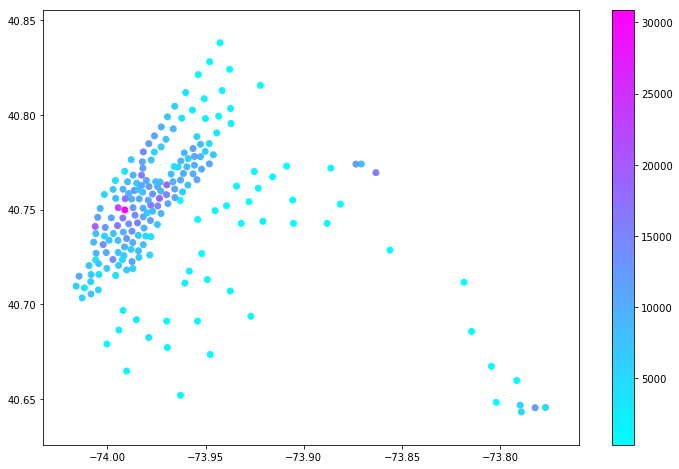

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(x=clf_pu.cluster_centers_[:,0],y=clf_pu.cluster_centers_[:,1],c=pu_cluster_counts,cmap='cool')
plt.colorbar();

In [32]:
data['pu_cluster'] = clf_pu.labels_

In [33]:
clf_do = MiniBatchKMeans(n_clusters=200,batch_size=10000)

In [34]:
clf_do.fit(data[['dropoff_longitude','dropoff_latitude']])

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=200, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [35]:
do_cluster_counts = pd.Series(clf_do.labels_).value_counts()
do_cluster_counts.sort_index(inplace=True)

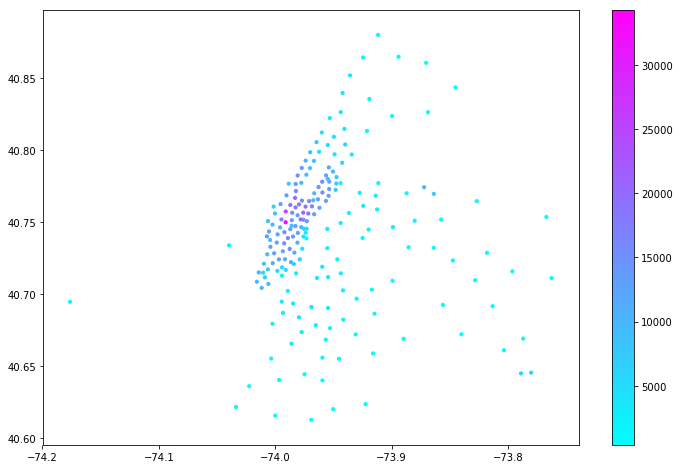

In [53]:
plt.figure(figsize=(12,8))
plt.scatter(x=clf_do.cluster_centers_[:,0],y=clf_do.cluster_centers_[:,1],c=do_cluster_counts,cmap='cool',s=10)
plt.colorbar()

In [37]:
data['do_cluster'] = clf_do.labels_

### Common routes

In [38]:
top_routes = data.groupby(['pu_cluster','do_cluster']).size().sort_values().tail(25)
top_routes = list(zip(top_routes.index.labels[0],top_routes.index.labels[1]))
top_routes[:5]

[(190, 56), (107, 141), (24, 69), (190, 7), (132, 7)]

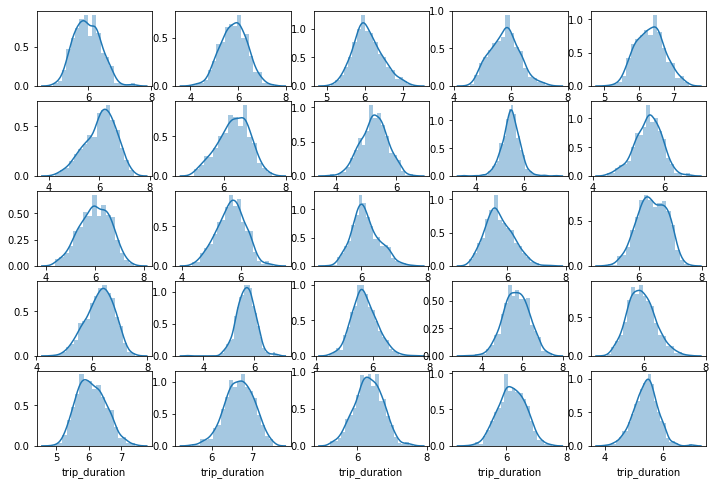

In [39]:
plt.figure(figsize=(12,8))
plt.subplot(5,5,1)
for i,route in enumerate(top_routes):
    ax = plt.subplot(5,5,i+1)
    durations = data[(data['pu_cluster'] == route[0]) & (data['do_cluster'] == route[1])]['trip_duration']
    durations = np.log(durations[durations < 2000])
    sns.distplot(durations,ax=ax)

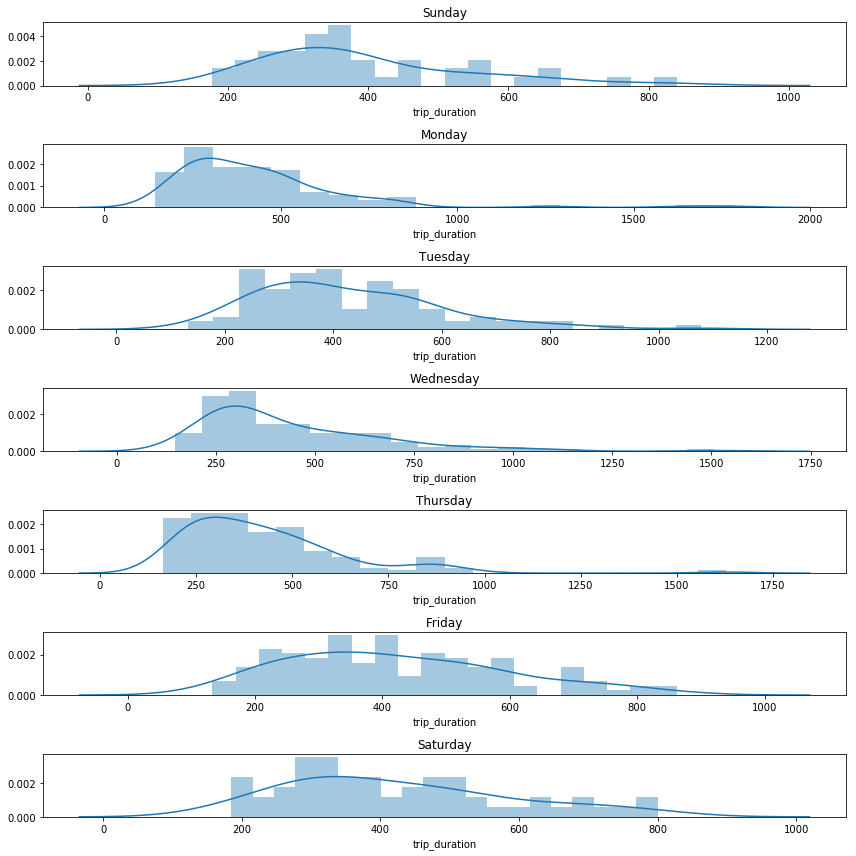

In [45]:
top_route = data[(data['pu_cluster'] == top_routes[0][0]) & (data['do_cluster'] == top_routes[0][1])].copy()
top_route.query('trip_duration < 5000',inplace=True)
plt.figure(figsize=(12,12))
plt.subplot(7,1,1)
for i, day in enumerate(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']):
    ax = plt.subplot(7,1,i+1)
    durations = top_route[top_route['dayofweek'] == day]['trip_duration']
    sns.distplot(durations,ax=ax,bins=20,norm_hist=True)
    plt.title(day)
    plt.tight_layout()

In [46]:
top_route_means = top_route.groupby(['hour','dayofweek'])['trip_duration'].mean().unstack().fillna(0)

In [47]:
top_route_means = top_route_means[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]

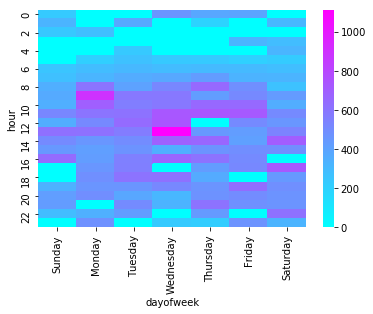

In [49]:
sns.heatmap(top_route_means,cmap='cool');

### Visualizations

In [6]:
manhattan = data[(data['pickup_longitude'] < -73.9) & (data['pickup_longitude'] > -74.025) & (data['pickup_latitude'] < 40.85) & (data['pickup_latitude'] > 40.7)]

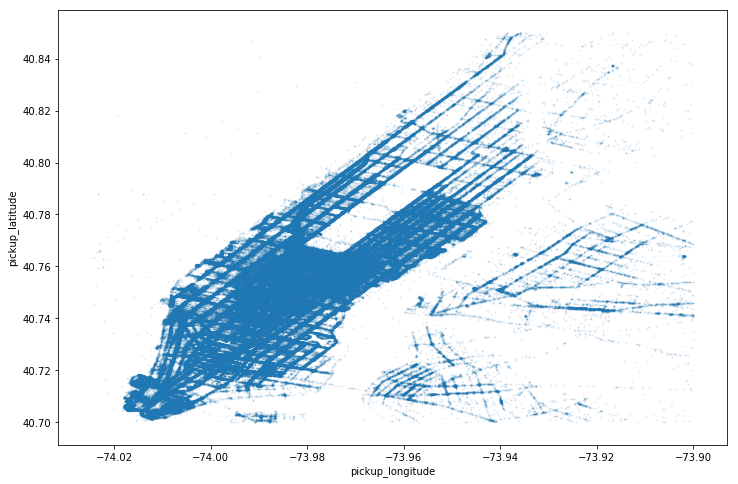

In [7]:
manhattan.plot(kind='scatter',x='pickup_longitude', y="pickup_latitude",alpha=0.1,s=1,figsize=(12,8))